In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

import sys, os
from pathlib import Path
import numpy as np
from scipy import stats
import xarray as xr
import scipy as sp
import h5py

# plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

import holoviews as hv
from holoviews import opts
hv.extension('bokeh', 'matplotlib')

data_root = Path('../data/BIOQIC')
sys.path.append('..')
%aimport mre_siren

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# BIOQIC phantom MRE data

Read in the matlab files as dict-like objects and display metadata about their contents, e.g. data types and array shapes. The files were created in two different versions of matlab, so we need to use either `scipy.io.loadmat` or `h5py.File` to read them.

In [ ]:
def load_mat_data(mat_file, verbose=False):
    try:
        data = sp.io.loadmat(mat_file)
    except NotImplementedError as e:
        # Please use HDF reader for matlab v7.3 files
        data = h5py.File(mat_file)
    if verbose:
        print(mat_file)
        print_mat_info(data, level=1)
    return data


def print_mat_info(d, level=0, tab=' '*4):
    for k, v in d.items():
        if hasattr(v, 'shape'):
            print(tab*level + f'{k}: {type(v)} {v.shape} {v.dtype}')
        else:
            print(tab*level + f'{k}: {type(v)}')
        if hasattr(v, 'items'):
            print_mat_info(v, level+1)

In [8]:
data_r = load_mat_data(str(data_root / 'phantom_raw.mat'), verbose=True)

FileNotFoundError: [Errno 2] No such file or directory: 'data/BIOQIC/phantom_raw.mat'

In [13]:
data_u = load_mat_data(data_root / 'phantom_unwrapped.mat', verbose=True)

data/BIOQIC/phantom_unwrapped.mat
    #refs#: <class 'h5py._hl.group.Group'>
        #a#: <class 'h5py._hl.dataset.Dataset'> (24, 1) uint16
        #b#: <class 'h5py._hl.dataset.Dataset'> (27, 1) uint16
        #c#: <class 'h5py._hl.dataset.Dataset'> (26, 1) uint16
        #d#: <class 'h5py._hl.dataset.Dataset'> (15, 1) uint16
        #e#: <class 'h5py._hl.dataset.Dataset'> (39, 1) uint16
        #f#: <class 'h5py._hl.dataset.Dataset'> (15, 1) uint16
    info: <class 'h5py._hl.group.Group'>
        dx_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
        dy_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
        dz_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
        frequencies_Hz: <class 'h5py._hl.dataset.Dataset'> (8, 1) float64
        index_description: <class 'h5py._hl.dataset.Dataset'> (1, 6) object
        size: <class 'h5py._hl.dataset.Dataset'> (6, 1) float64
    magnitude: <class 'h5py._hl.dataset.Dataset'> (8, 3, 8, 25, 128, 80) float64
    phase_unwrapp

In [14]:
data_d = load_mat_data(data_root / 'phantom_unwrapped_dejittered.mat', verbose=True)

data/BIOQIC/phantom_unwrapped_dejittered.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
    magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
    phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) float64


In [15]:
data_c = load_mat_data(data_root / 'phantom_raw_complex.mat', verbose=True)

data/BIOQIC/phantom_raw_complex.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    cube: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) complex128
    voxelsizem: <class 'numpy.ndarray'> (1, 3) float64
    frequenciesHz: <class 'numpy.ndarray'> (1, 8) uint8


In [16]:
data_c['frequenciesHz']

array([[ 30,  40,  50,  60,  70,  80,  90, 100]], dtype=uint8)

In [17]:
resolution = data_c['voxelsizem'][0]
resolution

array([0.0015, 0.0015, 0.0015])

# Convert data to xarray Dataset

Each of the arrays have the same shape and metadata, so we can read them each into `xr.DataArray` objects stored in a single `xr.Dataset`. Note that the data arrays that use the older matlab format have reversed axes order, so we transpose them to make all the indexes the same. We also make sure everthing is the same data type by promoting to `np.float64` or splitting the real and imaginary parts of the complex data.

In [18]:
# metadata from pdf doc applies to all data
metadata = dict(
    dims=['freq', 'MEG', 't', 'z', 'x', 'y'],
    coords=dict(
        freq=[30, 40, 50, 60, 70, 80, 90, 100],
        MEG=range(3), #'y', 'x', 'z'],
        t=np.arange(8) / 8,
        z=np.arange(25) * 1.5,
        x=np.arange(128) * 1.5,
        y=np.arange(80) * 1.5,
    )
)

# reverse matlab axes order
rev_axes = range(6)[::-1]

# create xarray dataset from downloaded files
ds = xr.Dataset(dict(
    magnitude_raw=xr.DataArray(data_r['magnitude'], **metadata),
    magnitude_unwrap=xr.DataArray(data_u['magnitude'], **metadata),
    magnitude_dejit=xr.DataArray(
        data_d['magnitude'].transpose(rev_axes).astype(np.float64),
        **metadata
    ),
    phase_raw=xr.DataArray(data_r['phase'], **metadata),
    phase_unwrap=xr.DataArray(data_u['phase_unwrapped'], **metadata),
    phase_dejit = xr.DataArray(
        data_d['phase_unwrap_noipd'].transpose(range(6)[::-1]),
        **metadata
    ),
    cube_real = xr.DataArray(
        data_c['cube'].real.transpose(rev_axes), **metadata
    ),
    cube_imag = xr.DataArray(
        data_c['cube'].imag.transpose(rev_axes), **metadata
    )
))
ds

<xarray.Dataset>
Dimensions:           (freq: 8, MEG: 3, t: 8, z: 25, x: 128, y: 80)
Coordinates:
  * freq              (freq) int64 30 40 50 60 70 80 90 100
  * MEG               (MEG) int64 0 1 2
  * t                 (t) float64 0.0 0.125 0.25 0.375 0.5 0.625 0.75 0.875
  * z                 (z) float64 0.0 1.5 3.0 4.5 6.0 ... 31.5 33.0 34.5 36.0
  * x                 (x) float64 0.0 1.5 3.0 4.5 ... 186.0 187.5 189.0 190.5
  * y                 (y) float64 0.0 1.5 3.0 4.5 ... 114.0 115.5 117.0 118.5
Data variables:
    magnitude_raw     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 41.0 78.0
    magnitude_unwrap  (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 41.0 78.0
    magnitude_dejit   (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 41.0 78.0
    phase_raw         (freq, MEG, t, z, x, y) float64 0.0 0.0 ... 1.364 2.938
    phase_unwrap      (freq, MEG, t, z, x, y) float64 4.695e-09 ... -3.346
    phase_dejit       (freq, MEG, t, z, x, y) float64 -0.6366 -1.153 ... -3.561
    cube_real         (freq, MEG, t, z, x, y) float64 0.0 0.0 ... 8.43 -76.38
    cube_imag         (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 40.12 15.8

In [19]:
# descriptive statistics
ds.to_dataframe().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
magnitude_raw,49152000.0,313.954245,233.221729,0.000000,59.000000,425.000000,522.000000,2796.000000
magnitude_unwrap,49152000.0,313.954245,233.221729,0.000000,59.000000,425.000000,522.000000,2796.000000
magnitude_dejit,49152000.0,313.954245,233.221729,0.000000,59.000000,425.000000,522.000000,2796.000000
phase_raw,49152000.0,-0.044564,1.586261,-3.141593,-1.199573,-0.069029,1.107534,3.141593
phase_unwrap,49152000.0,0.930254,13.145816,-382.237333,-1.587671,0.194816,3.152331,394.452422
phase_dejit,49152000.0,0.930749,10.594018,-293.254524,-1.548938,0.181480,2.932810,302.263166
cube_real,49152000.0,96.242596,270.731862,-2297.871142,-33.276906,32.139456,327.953198,2686.298212
cube_imag,49152000.0,-14.195944,264.952338,-2729.929769,-128.081800,-3.900401,79.083353,2302.279826


Some initial observations from the descriptive statistics: All of the magnitude images have the same exact statistics, which leads me to believe that they may be the same underlying values. This is not the case for the phase images. Notice that the raw phase values are constrained to the range $[-\pi, \pi]$, but the unwrapped and dejittered phase values have a much wider range.

# Visualize the phantom data

We can create color maps for displaying the magnitude and phase images, then visualize slices of the data using grids of matplotlib subplots.

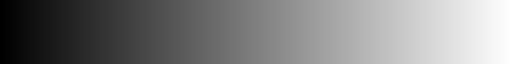

In [20]:
magnitude_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='magnitude', colors=[(0,0,0), (1,1,1)], N=255
)
magnitude_cmap

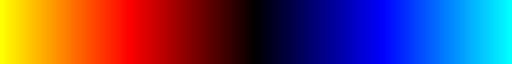

In [21]:
phase_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='phase', colors=[(1,1,0), (1,0,0), (0,0,0), (0,0,1), (0,1,1)], N=255
)
phase_cmap

In [22]:
# this is the inverse of the phase colormap
#   i.e. it maps colors back to phase values
# we don't need it now, but it could be useful

def rgb_to_phase(rgb):
    assert rgb.shape[-1] == 3
    assert ((0 <= rgb) & (rgb <= 1)).all()
    r = rgb[...,0]
    g = rgb[...,1]
    b = rgb[...,2]
    y = np.where(r == 1, g, 0)
    c = np.where(b == 1, g, 0)
    return (y + r - b - c)/2
    
rgb_to_phase(np.array([
    [1, 1, 0],
    [1, 0, 0],
    [0, 0, 0],
    [0, 0, 1],
    [0, 1, 1],
    [1, 1, 1]
]))

array([ 1. ,  0.5,  0. , -0.5, -1. ,  0. ])

In [23]:
def plot_mre_data(data, cmap, v_min, v_max, t=0, z=0):

    # recreate the sample image
    n_rows = 8
    n_cols = 6
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(2.5*n_cols, 2.5*n_rows),
        gridspec_kw=dict(
            width_ratios=[7,1]*(n_cols//2),
            wspace=0.2,
            hspace=0.2
        )
    )
    for i in range(n_rows): # frequency
        for j in range(n_cols): # MEG direction

            ax = axes[i,j]
            im = np.array(data[i,j//2,t,z,:,:].T)

            if j%2 == 0: # show image slice
                ax.imshow(im, cmap=cmap, vmin=v_min, vmax=v_max)
                ax.set_xticks([])
                ax.set_yticks([])
                xlabel = f'{i}, {j}'
        
            else: # box plot of image values
                ax.boxplot(x=im.flatten(), widths=0.5, sym='')
                xlabel = f''
                ax.spines['bottom'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                ax.set_xticks([])

            if j == 0:
                ax.set_ylabel(f'{data.coords["freq"][i].values} Hz')
            if i == 7:
                xlabel += '\n' + str(data.coords['MEG'][j//2].values)
            ax.set_xlabel(xlabel)
    return fig

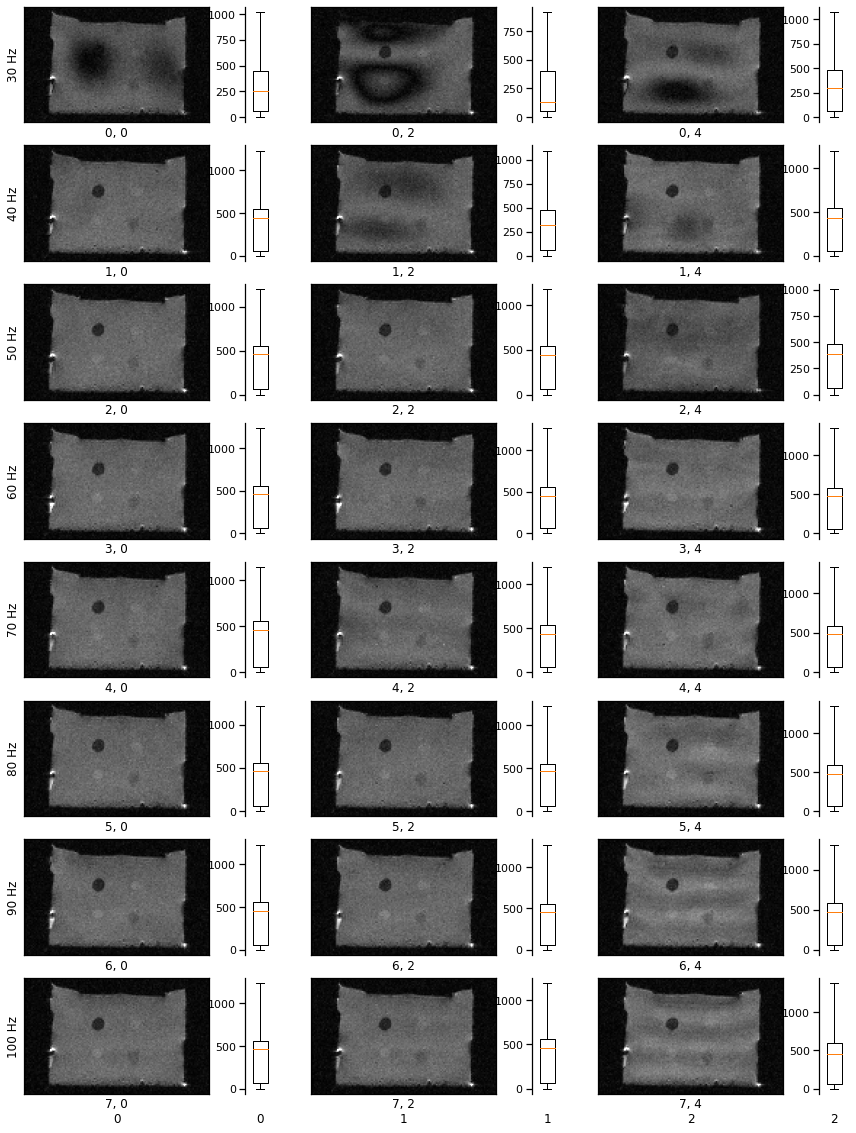

In [24]:
plot_mre_data(ds['magnitude_raw'], cmap=magnitude_cmap, v_min=0, v_max=2796/2)

The magnitude values are highly right-skewed, so the images look very dark if we plot the full value range. By reducing the maximum intensity, you can see the locations of the four cylindrical inclusions in the images.

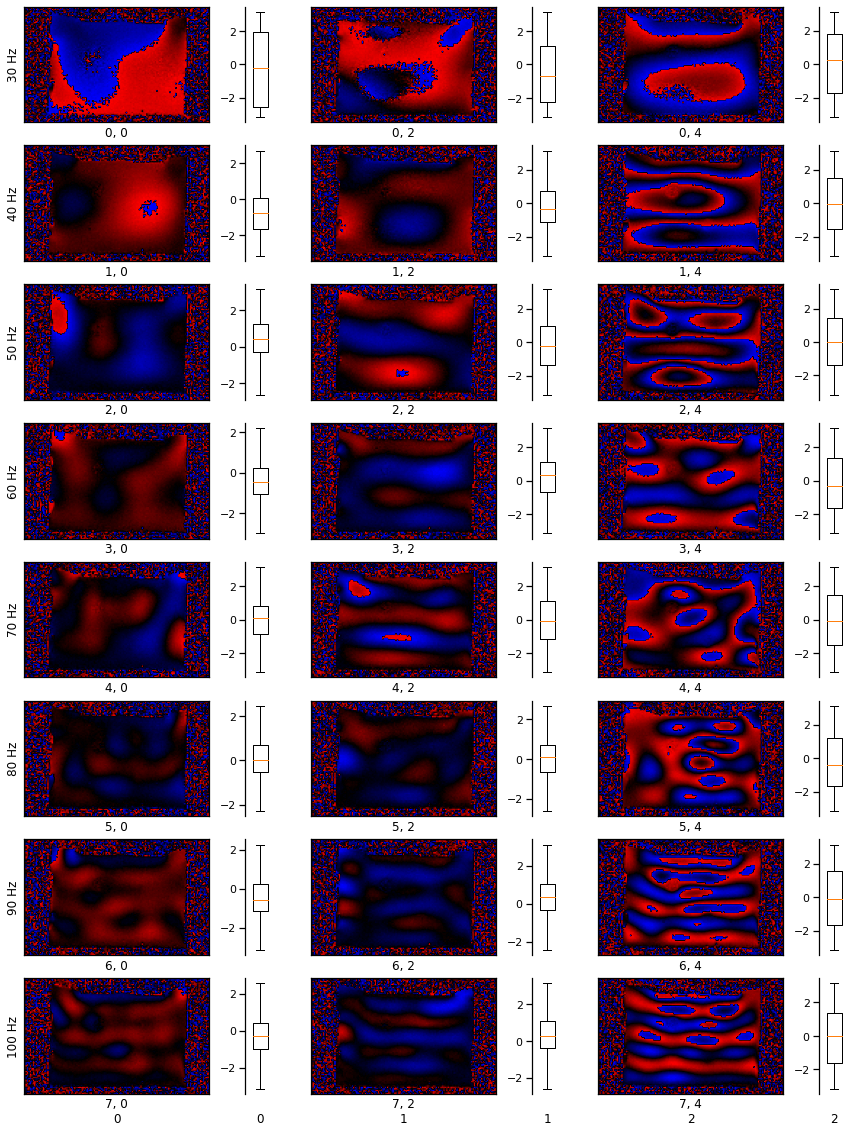

In [25]:
plot_mre_data(ds['phase_raw'], cmap=phase_cmap, v_min=-2*np.pi, v_max=2*np.pi)

The raw phase data is confined to the range corresponding to a single periodic cycle, but when we visualize the data it is apparent that there are discontinuities. This can be seen in the areas were the color values abruptly switch from the maximum value to the minimum or vice versa.

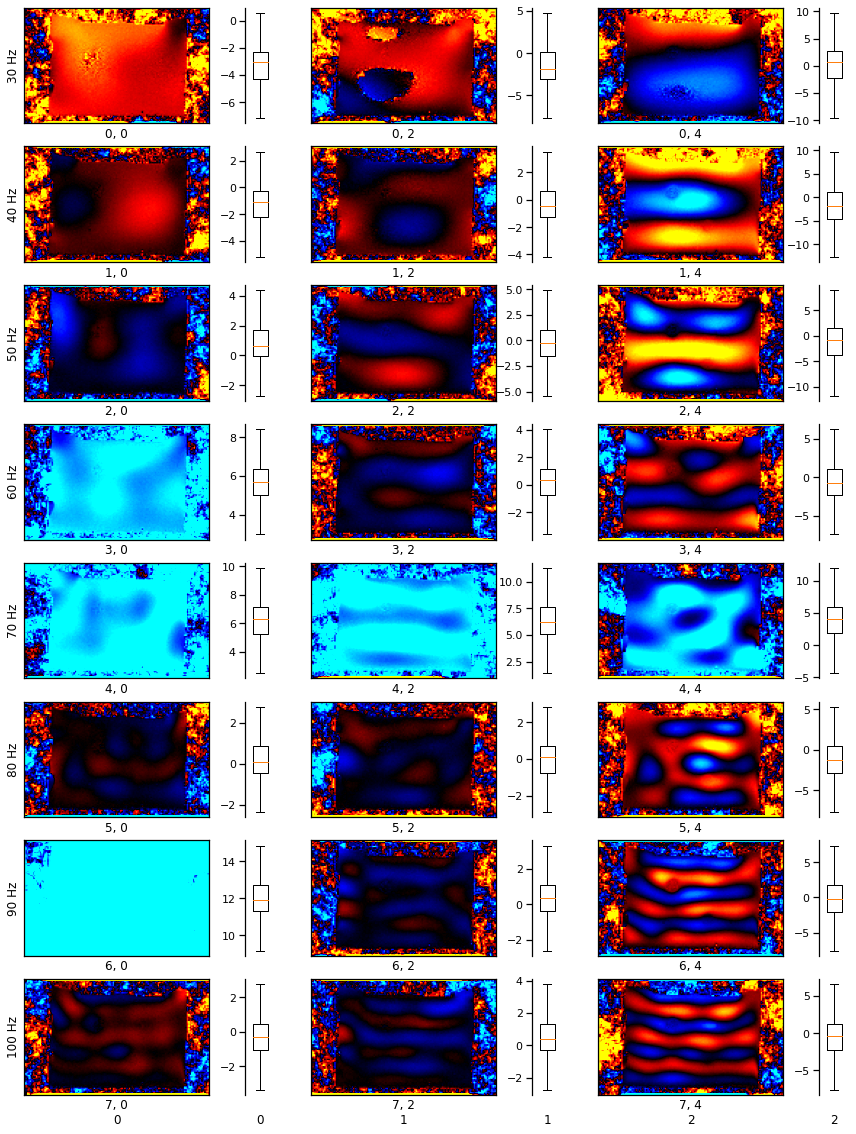

In [26]:
plot_mre_data(ds['phase_unwrap'], cmap=phase_cmap, v_min=-2*np.pi, v_max=2*np.pi)

After unwrapping the phase data, the discontinuities have mostly been fixed. As a result the phase data is no longer confined to the range of $[\pi, \pi]$, so we can expand the value range to see the smoother shape of the information. Now we notice that there are still some artifacts, such as the fact the certain slices have much higher mean intensity, or the presence of phase "holes" where the values are still discontinuous.

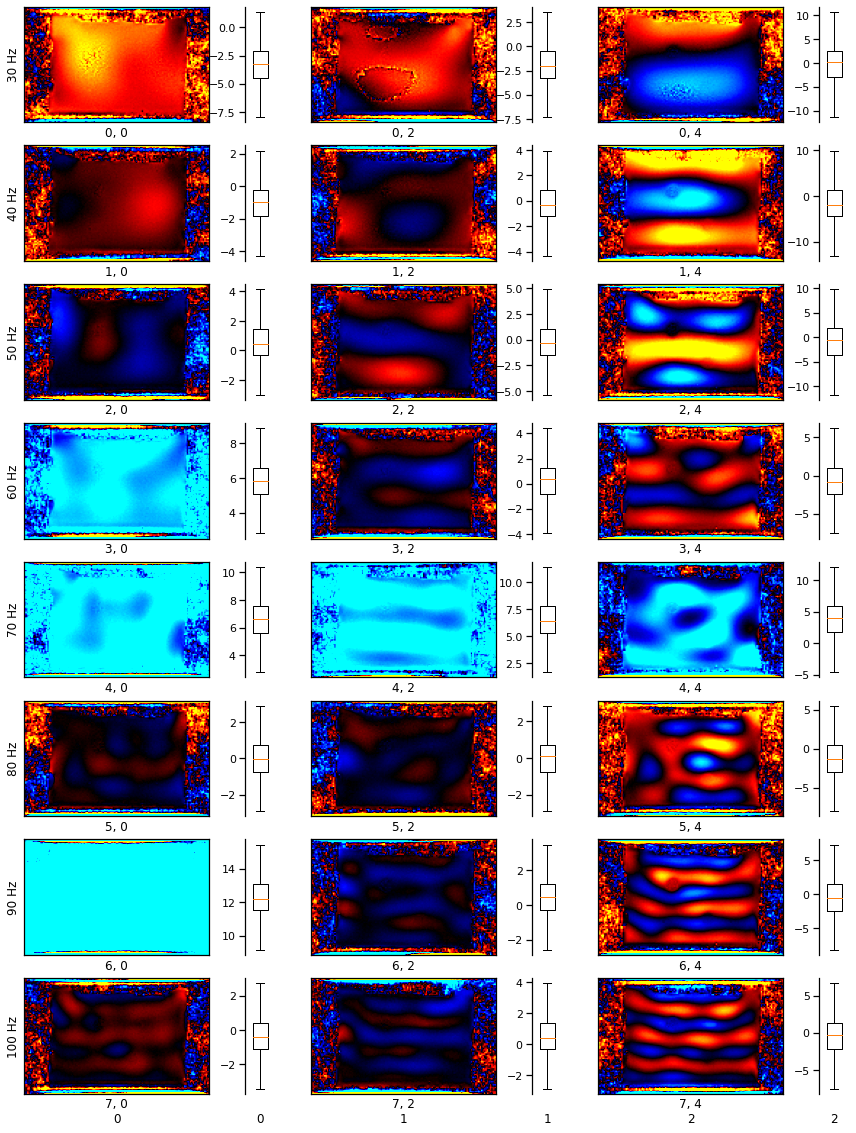

In [27]:
plot_mre_data(ds['phase_dejit'], cmap=phase_cmap, v_min=-2*np.pi, v_max=2*np.pi)

The final processing step attempts to repair the remaining discontinuities in the phase data. However it does not try to correct shifted intensity ranges of certain slices. From the data description, we know that the slices can be shifted by integer multiples of $2\pi$. They state that the reason their inversion pipeline only works on 2D slices (not 3D) is due to the presence of these phase shifts between slices.

I wonder if we could simply estimate the phase shift of each slice and subtract it. Then we might be able to apply 3D inversion techniques. This would rely on knowing something about the distribution of the phase values, for instance that they really are centered at zero for a given slice. We could also find a least squares solution, where each slice has some global phase shift parameter that gets optimized so that consecutive slices are similar.

# View the data interactively

In [28]:
def view_xarray(ds, x, y, hue, cmap, v_range, scale):
    return hv.Dataset(ds[hue]).to(hv.Image, [x, y], dynamic=True).opts(
        cmap=cmap,
        width=scale*ds.dims[x],
        height=scale*ds.dims[y]
    ).redim.range(**{hue: tuple(v_range)}).hist()


phase_range = np.array([-np.pi, np.pi])
magnitude_range = np.array([0, 2796])

hv.Layout([
    view_xarray(ds, x='x', y='y', hue='magnitude_raw', cmap=magnitude_cmap, v_range=magnitude_range/2, scale=2),
    view_xarray(ds, x='x', y='y', hue='phase_raw', cmap=phase_cmap, v_range=2*phase_range, scale=2),
    view_xarray(ds, x='x', y='y', hue='phase_unwrap', cmap=phase_cmap, v_range=2*phase_range, scale=2),
    view_xarray(ds, x='x', y='y', hue='phase_dejit', cmap=phase_cmap, v_range=2*phase_range, scale=2),
]).cols(1)

:Layout
   .AdjointLayout.I   :AdjointLayout
      :DynamicMap   [freq,MEG,t,z]
         :Image   [x,y]   (magnitude_raw)
      :DynamicMap   [freq,MEG,t,z]
         :Histogram   [magnitude_raw]   (magnitude_raw_count)
   .AdjointLayout.II  :AdjointLayout
      :DynamicMap   [freq,MEG,t,z]
         :Image   [x,y]   (phase_raw)
      :DynamicMap   [freq,MEG,t,z]
         :Histogram   [phase_raw]   (phase_raw_count)
   .AdjointLayout.III :AdjointLayout
      :DynamicMap   [freq,MEG,t,z]
         :Image   [x,y]   (phase_unwrap)
      :DynamicMap   [freq,MEG,t,z]
         :Histogram   [phase_unwrap]   (phase_unwrap_count)
   .AdjointLayout.IV  :AdjointLayout
      :DynamicMap   [freq,MEG,t,z]
         :Image   [x,y]   (phase_dejit)
      :DynamicMap   [freq,MEG,t,z]
         :Histogram   [phase_dejit]   (phase_dejit_count)

An observation about the phase shift issue: The problem is exemplified by looking at `freq=90` and `MEG=0`. Notice that the unwrapped and dejittered phases images are almost entirely cyan, i.e. their phase values are at or above $2\pi$. If you change the z and t sliders, all of the values are shifted. This suggests that the phase shifts are only between different (frequency, MEG) indices, and all of the x,y,z,t values for a given (frequency,MEG) index are shifted by the same amount.

In [29]:
def phase_to_complex(phase, conj=False):
    '''
    Convert phase to complex value.
    This is the inverse of np.angle,
    up to an integer multiple of 2 pi.
    '''
    if conj:
        return np.exp(-1j*phase)
    else:
        return np.exp(1j*phase)

A = np.random.randn(1000)
(np.angle(phase_to_complex(A)) - A).max() % (2*np.pi)

0.0

# Complex phase data

We should check that `phase_raw` and `phase_raw_complex` represent the same exact information by taking the angle of the complex values.

$$
\begin{align}
    z = x + yi &= |z|\cdot(\cos \phi + i \sin \phi) = |z|\cdot e^{i\phi} \\
    z = x - yi &= |z|\cdot(\cos \phi - i \sin \phi) = |z|\cdot e^{-i\phi}
\end{align}
$$

In [38]:
# verify that phase raw is just the angle of phase raw complex
ds['cube_phase'] = xr.ufuncs.angle(ds['cube_real'] + 1j*ds['cube_imag'])
ds[['phase_raw', 'cube_phase']].to_dataframe().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
phase_raw,49152000.0,-0.044564,1.586261,-3.141593,-1.199573,-0.069029,1.107534,3.141593
cube_phase,49152000.0,-0.044484,1.586237,-3.141593,-1.199573,-0.069029,1.107534,3.141593


After taking the complex angle, the statistics of the resulting array are identical to `phase_raw`, indicating that they represent the same information.

In [39]:
hv.Layout([
    view_xarray(ds, x='x', y='y', hue='phase_raw', cmap=phase_cmap, v_range=2*phase_range, scale=2),
    view_xarray(ds, x='x', y='y', hue='cube_phase', cmap=phase_cmap, v_range=2*phase_range, scale=2),
]).cols(1)

:Layout
   .AdjointLayout.I  :AdjointLayout
      :DynamicMap   [freq,MEG,t,z]
         :Image   [x,y]   (phase_raw)
      :DynamicMap   [freq,MEG,t,z]
         :Histogram   [phase_raw]   (phase_raw_count)
   .AdjointLayout.II :AdjointLayout
      :DynamicMap   [freq,MEG,t,z]
         :Image   [x,y]   (cube_phase)
      :DynamicMap   [freq,MEG,t,z]
         :Histogram   [cube_phase]   (cube_phase_count)

Question- isn't some information lost since we are only using the complex angle and not the absolute value?

In [40]:
# two complex numbers can have the same angle but different absolute value
v1 = 1 + 1j
v2 = 2 * v1
[
    (np.absolute(v1), np.angle(v1)),
    (np.absolute(v2), np.angle(v2))
]

[(1.4142135623730951, 0.7853981633974483),
 (2.8284271247461903, 0.7853981633974483)]

## Estimating phase shift

In [41]:
def estimate_phase_shift(a, **kwargs):
    return np.round(np.median(a, **kwargs) / (2*np.pi))

In [42]:
# median estimation of phase shift for each (frequency, MEG)
#   what are we minimizing?
phase_shift = estimate_phase_shift(ds['phase_unwrap'], axis=(2,3,4,5), keepdims=True)
phase_shift.shape

(8, 3, 1, 1, 1, 1)

In [43]:
hv.Layout([
    view_xarray(ds - (phase_shift*2*np.pi), x='x', y='y', hue='phase_unwrap', cmap=phase_cmap, v_range=2*phase_range, scale=2),
]).cols(1)

:Layout
   .AdjointLayout.I :AdjointLayout
      :DynamicMap   [freq,MEG,t,z]
         :Image   [x,y]   (phase_unwrap)
      :DynamicMap   [freq,MEG,t,z]
         :Histogram   [phase_unwrap]   (phase_unwrap_count)

In [44]:
phase_shift.squeeze()

array([[-0.,  0., -0.],
       [-0., -0., -0.],
       [-0., -0., -0.],
       [ 1.,  0., -0.],
       [ 1.,  1.,  1.],
       [-0.,  0., -0.],
       [ 2.,  0., -0.],
       [-0.,  0., -0.]])